In [2]:

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools

import scipy.signal as signal


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["figure.titlesize"] = 25

In [481]:
dt = 100.
tmax = 5e6
times = np.arange(0,tmax,dt)
osc = np.arange(0,tmax,dt)
ev = np.zeros(len(osc),dtype=complex)
pev = np.zeros(len(osc),dtype=complex)


#three modes, g1 is "free/proper" and g2/g3 are "planets"

#periods in years
tau_p =1e5
tau_g1 = 1e3
tau_g2 = 6e5

#frequencies in rad/yr
gp = 2.*np.pi/tau_p
g1 = 2.*np.pi/tau_g1
g2 = 2.*np.pi/tau_g2

proper = 2.*np.sin(times*gp+0.287)

osc = 2.*np.sin(times*gp+0.287) + 0.5*np.sin(times*g1+2.37) + 3.2*np.sin(times*g2+1.37)


for n in range(0,len(osc)):
    r = 2.*np.sin(times[n]*gp+0.287) + 0.5*np.sin(times[n]*g1+2.37) + 3.2*np.sin(times[n]*g2+1.37) 
    im = (2.*np.cos(times[n]*gp+0.287) + 0.5*np.cos(times[n]*g1+2.37) + 3.2*np.cos(times[n]*g2+1.37))
    ev[n] = 1j*im + r
    r = 2.*np.sin(times[n]*gp+0.287)
    im = 2.*np.cos(times[n]*gp+0.287)
    pev[n] = 1j*im + r
    

planet1 = 2.5*np.sin(times*g1+2.37)
planet2 = 1*np.sin(times*g2+1.37)

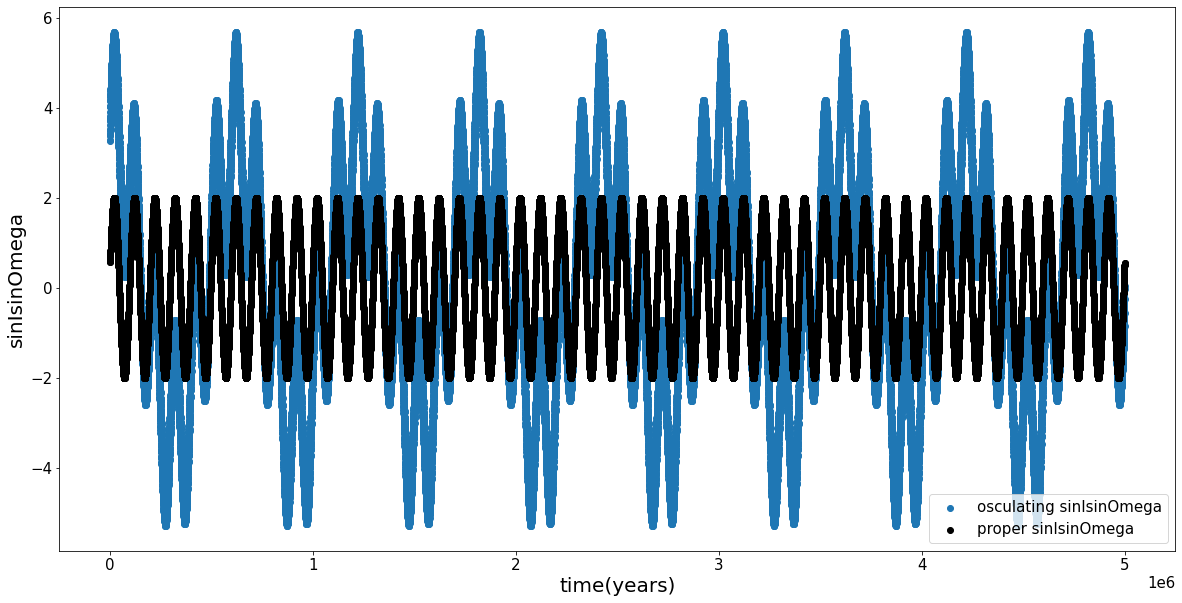

In [393]:
plt.scatter(times,osc,label='osculating sinIsinOmega');
plt.scatter(times,proper, label='proper sinIsinOmega',c='k');
plt.legend();
plt.xlabel('time(years)');

plt.ylabel('sinIsinOmega');
#plt.xlim([0,2]);

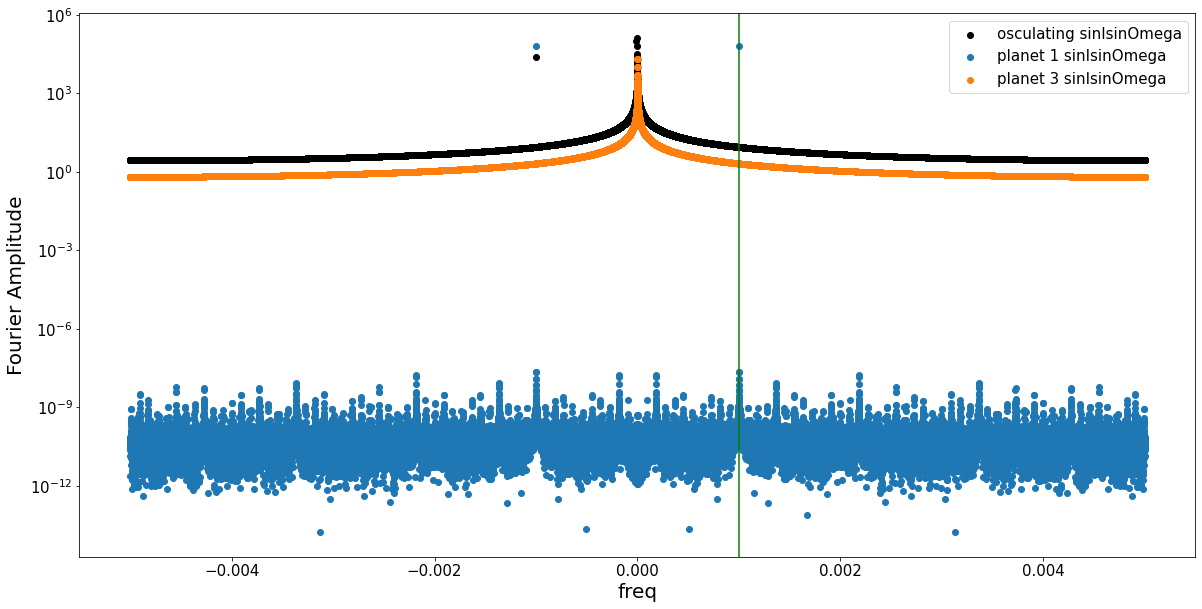

In [397]:
#calculate and plot the FFT power spectrum
n = len(osc)
#set of frequencies in the FFT
freq = np.fft.fftfreq(n,d=dt)
#FFT
Y = np.fft.fft(ev)
Yr = np.fft.fft(osc)

#FFTs of the "planets"
YP1 = np.fft.fft(planet1)
YP2 = np.fft.fft(planet2)

#translate to power 
pY = (np.abs(Y))
pYP1 = (np.abs(YP1))
pYP2 = (np.abs(YP2))

#plot the power spectrum (leaving off the frequency=0 term))
plt.scatter(freq[1:],pY[1:],label='osculating sinIsinOmega',c='k');
plt.scatter(freq[1:],pYP1[1:],label='planet 1 sinIsinOmega');
plt.scatter(freq[1:],pYP2[1:],label='planet 3 sinIsinOmega');
plt.legend();

plt.axvline(x=g1/(2.*np.pi),c='g')

plt.xlabel('freq');
plt.ylabel('Fourier Amplitude');
#plt.xscale('log');
plt.yscale('log');
#plt.xlim([0,50]);

In [319]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

In [396]:
sample_rate = 1./dt
print(sample_rate)
nyq_rate = sample_rate / 2.0
print(nyq_rate)
print(freq)
print(gp/(2.*np.pi)/nyq_rate)

print(g1/(2.*np.pi)/nyq_rate)

print(g2/(2.*np.pi)/nyq_rate)

#print(gp/nyq_rate,g1/nyq_rate,g2/nyq_rate)

0.01
0.005
[ 0.e+00  2.e-07  4.e-07 ... -6.e-07 -4.e-07 -2.e-07]
0.0019999999999999996
0.2
0.0003333333333333333


In [497]:
#width = 1./nyq_rate
width = 0.000001/nyq_rate
ripple_db = 44.0
N, beta = kaiserord(ripple_db, width)
print(N)
print(width)

25111
0.00019999999999999998


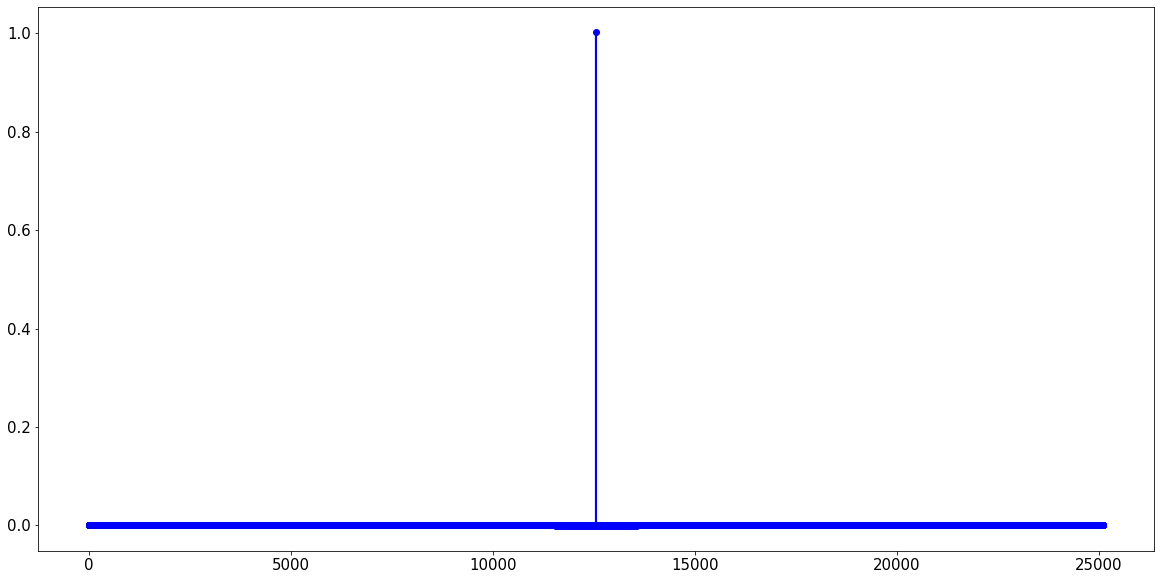

In [498]:
#taps = firwin(N, [0.0001,0.0006,0.19,0.21], window=('kaiser', beta))

taps = firwin(N, [width,4.*width,g1/(2.*np.pi)/nyq_rate-3.*width,g1/(2.*np.pi)/nyq_rate+3.*width], window=('kaiser', beta))


#taps = firwin(N, [0.5/nyq_rate,5/nyq_rate,20/nyq_rate,40/nyq_rate], window=('kaiser', beta))
filtered_x = lfilter(taps, 1.0, ev)
plot(taps, 'bo-', linewidth=2)

25111


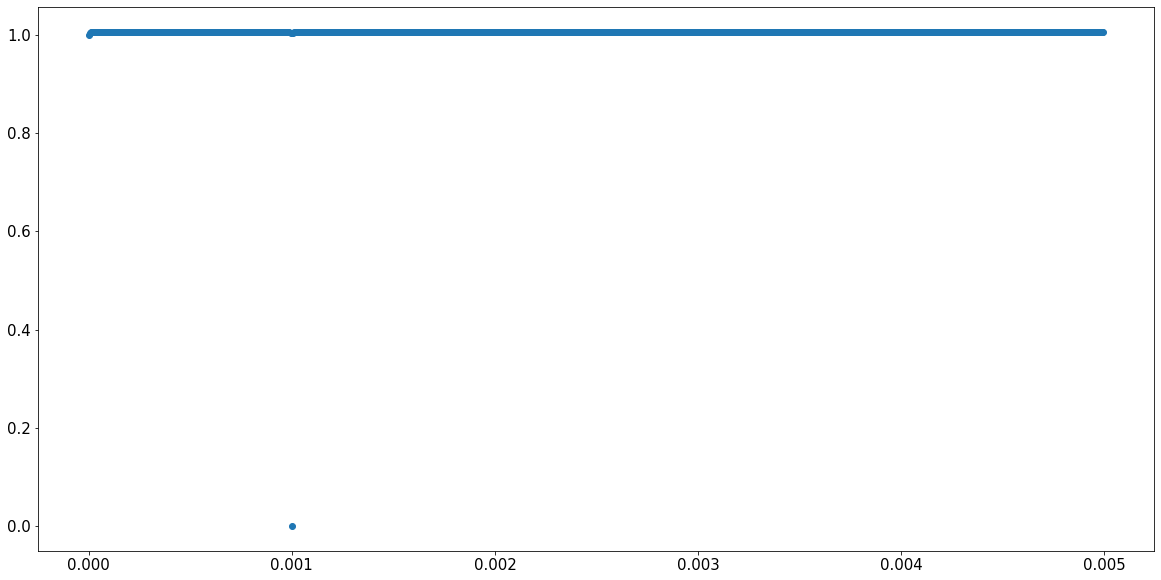

In [499]:
#print(taps)
print(N)
w, h = freqz(taps, worN=800)
plt.scatter(w/np.pi*nyq_rate, np.abs(h))
#plt.xlim([0,200]);

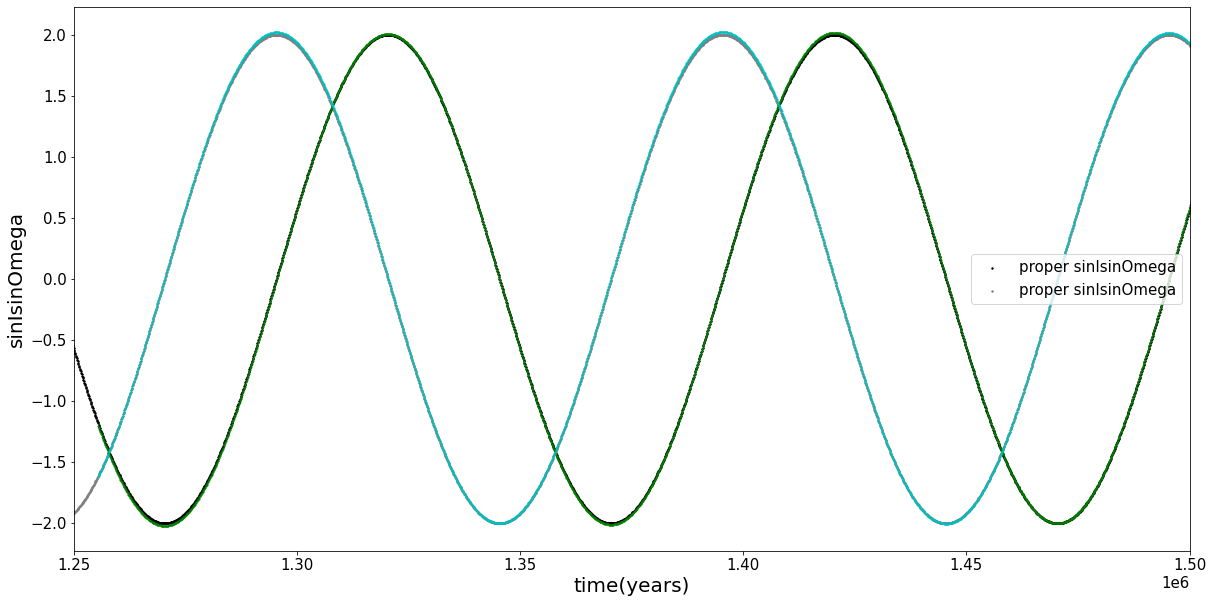

In [500]:
#plt.scatter(times,ev.real,label='osculating sinIsinOmega',s=4);
#plt.scatter(times,ev.imag,label='osculating sinIsinOmega',s=4);
plt.scatter(times,pev.real, label='proper sinIsinOmega',c='k',s=2);
plt.scatter(times,pev.imag, label='proper sinIsinOmega',c='gray',s=2);
delay = 0.5 * (N-1) / sample_rate
#plt.scatter(times,filtered_x.real, label='proper sinIsinOmega',c='r',s=5);
plt.scatter(times[N-1:]-delay, filtered_x[N-1:].real,s=1,c='g')
plt.scatter(times[N-1:]-delay, filtered_x[N-1:].imag,s=1,c='c')


#plt.scatter(times,filtered_x.imag, label='proper sinIsinOmega',c='k',s=5);
plt.legend();
plt.xlabel('time(years)');


plt.ylabel('sinIsinOmega');
plt.xlim([1.25e6,1.5e6]);

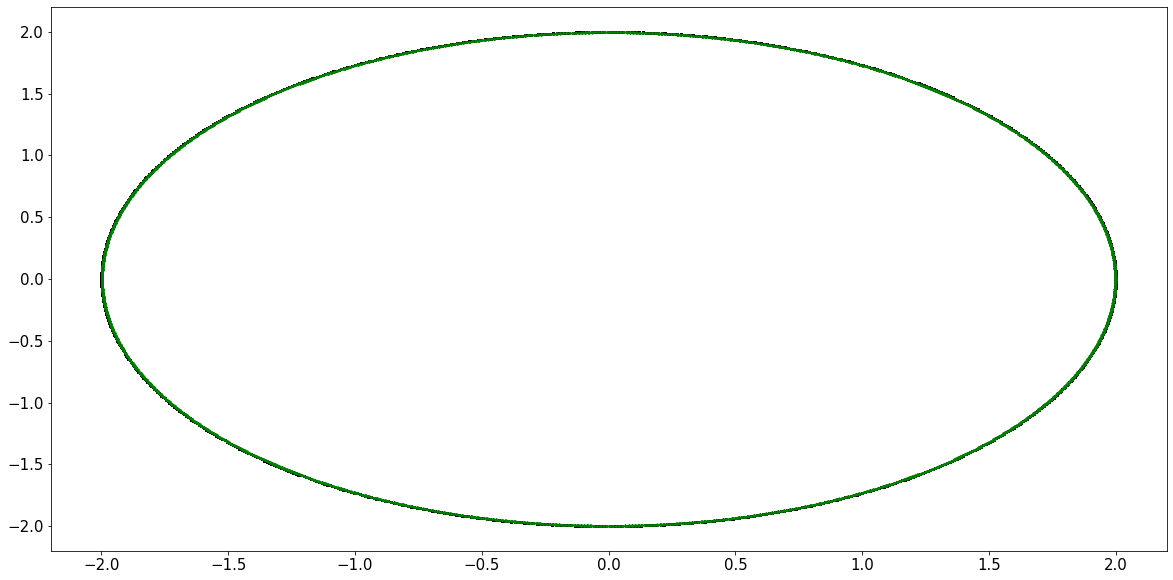

In [490]:
#plt.scatter(ev.real,ev.imag, s=1)
plt.scatter(pev.real,pev.imag, s=1,c='k')
plt.scatter(filtered_x[N-1:].real,filtered_x[N-1:].imag, s=1,c='g')


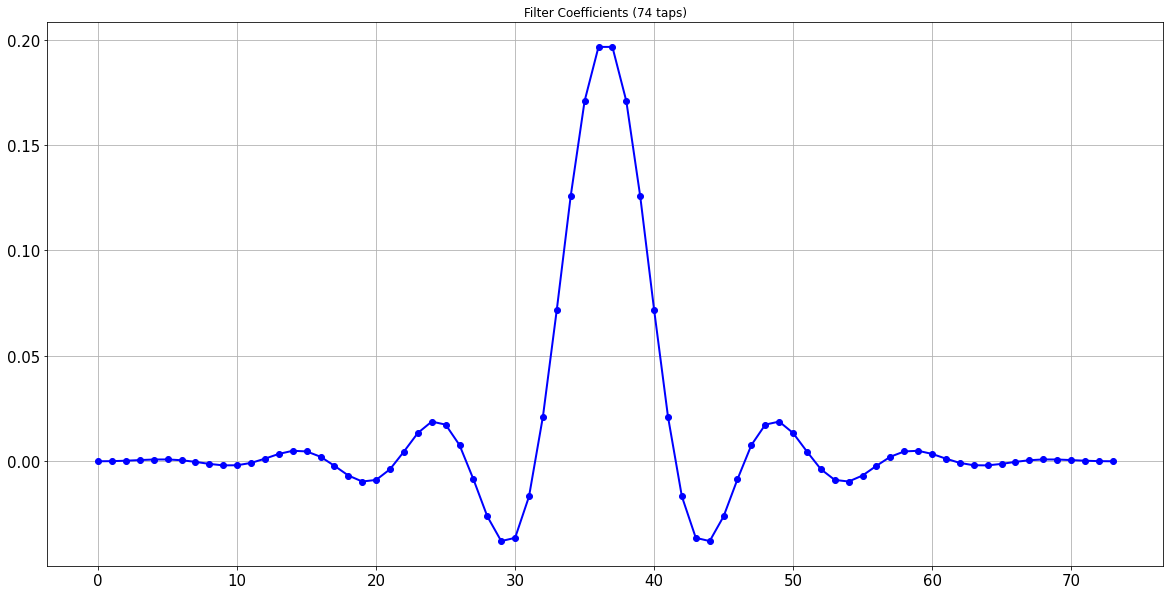

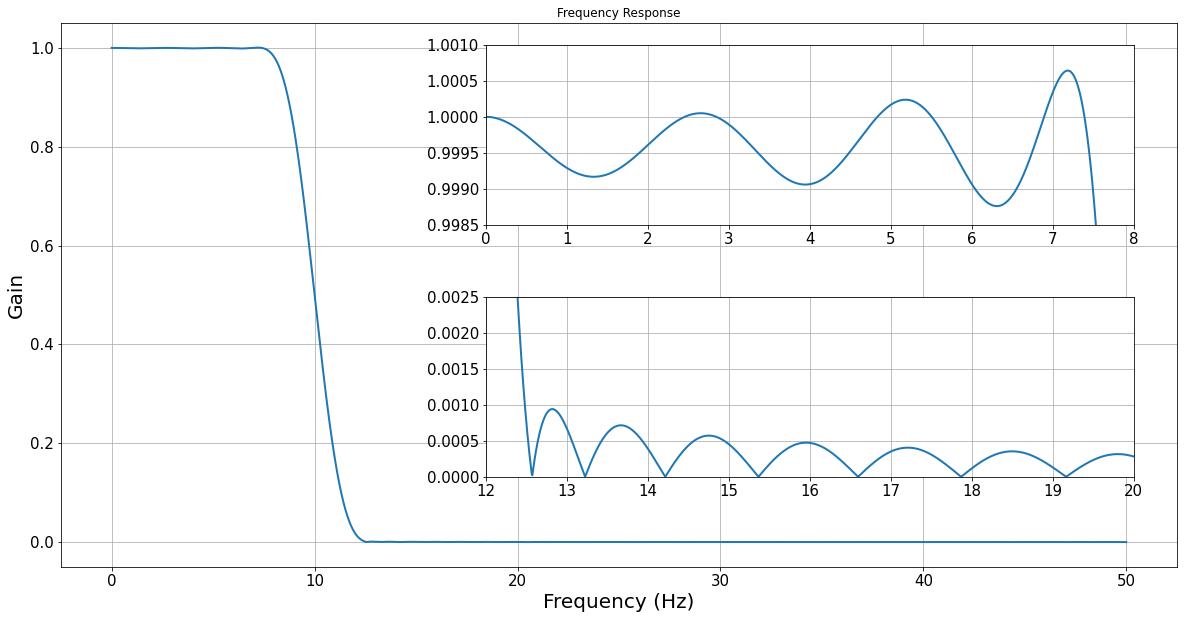

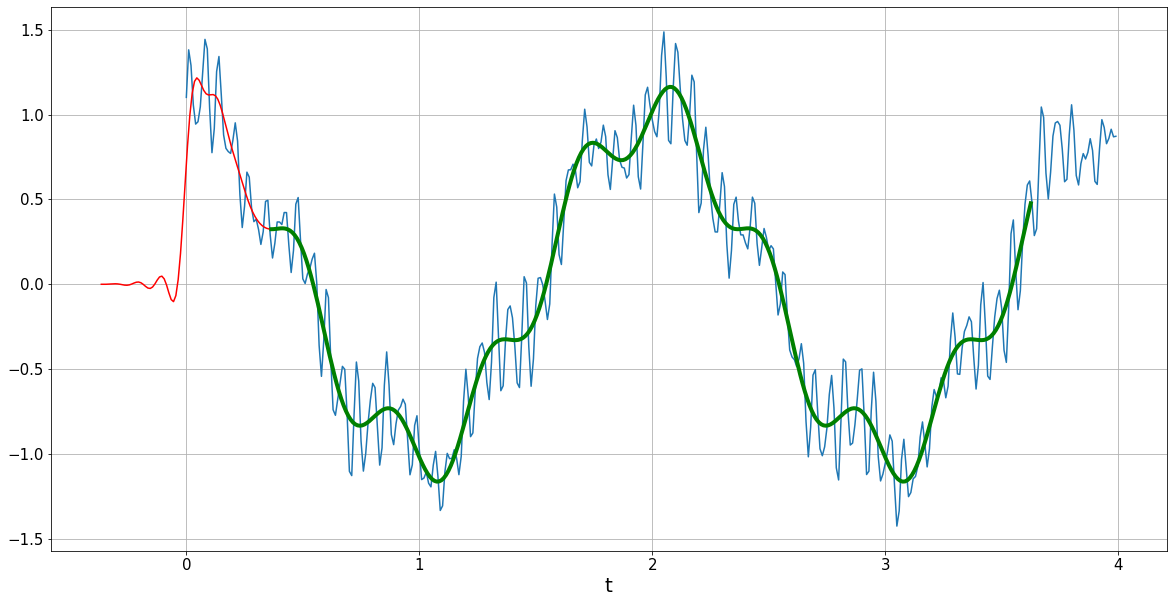

In [99]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show


#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 100.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()